# Instalar bibliotecas necesarias

In [1]:
#pip install torch torchvision torchaudio

In [2]:
#pip install tqdm

# Pre procesamiento de los datos

### Obtención de dimensiones y modos de color

Dimensiones y modos de color de las imágenes de entrenamiento:
[((400, 224), 'RGB'), ((400, 268), 'RGB'), ((400, 294), 'RGB'), ((400, 266), 'RGB'), ((400, 166), 'RGB'), ((400, 286), 'RGB'), ((400, 265), 'RGB'), ((400, 266), 'RGB'), ((400, 272), 'RGB'), ((400, 293), 'RGB')]

Dimensiones y modos de color de las imágenes de prueba:
[((400, 205), 'RGB'), ((400, 266), 'RGB'), ((400, 300), 'RGB'), ((400, 225), 'RGB'), ((400, 293), 'RGB'), ((400, 225), 'RGB'), ((400, 266), 'RGB'), ((400, 300), 'RGB'), ((400, 266), 'RGB'), ((400, 266), 'RGB')]

Dimensión más común: (400, 266)
Modo de color más común: RGB


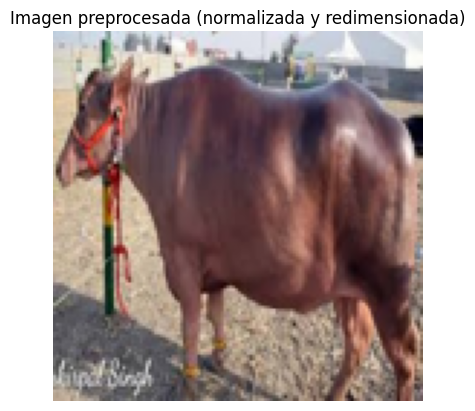

In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

def get_image_dimensions_and_channels(image_dir):
    dimensions = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    dimensions.append((img.size, img.mode))
    return dimensions

# Obtener dimensiones y modos de color para las imágenes de entrenamiento y prueba
train_dimensions = get_image_dimensions_and_channels(train_dir)
test_dimensions = get_image_dimensions_and_channels(test_dir)

# Visualizar dimensiones y modos de color
print("Dimensiones y modos de color de las imágenes de entrenamiento:")
print(train_dimensions[:10])  # Muestra solo las primeras 10 para no saturar la salida

print("\nDimensiones y modos de color de las imágenes de prueba:")
print(test_dimensions[:10])

# Buscar dimensiones y modos de color más comunes
train_dims, train_modes = zip(*train_dimensions)
test_dims, test_modes = zip(*test_dimensions)

common_dim = max(set(train_dims + test_dims), key=(train_dims + test_dims).count)
common_mode = max(set(train_modes + test_modes), key=(train_modes + test_modes).count)

print(f"\nDimensión más común: {common_dim}")
print(f"Modo de color más común: {common_mode}")

# Configuración para la transformación
resize_dim = (128, 128)
common_mode = "RGB"  # Usamos RGB para asegurar 3 canales

def preprocess_image(img_path, resize_dim, common_mode):
    with Image.open(img_path) as img:
        if img.mode != common_mode:
            img = img.convert(common_mode)
        img = img.resize(resize_dim)
        img = np.array(img) / 255.0  # Normalizar entre 0 y 1
    return img

# Visualizar ejemplo de imagen preprocesada
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
preprocessed_img = preprocess_image(sample_img_path, resize_dim, common_mode)

plt.imshow(preprocessed_img)
plt.title("Imagen preprocesada (normalizada y redimensionada)")
plt.axis("off")
plt.show()


### Preprocesamiento de una imagen de ejemplo

Número de imágenes de entrenamiento: 3200
Número de imágenes de prueba: 800
Dimensiones de las imágenes: (128, 128, 3)
Etiquetas: {'Buffalo': 0, 'Elephant': 1, 'Rhino': 2, 'Zebra': 3}


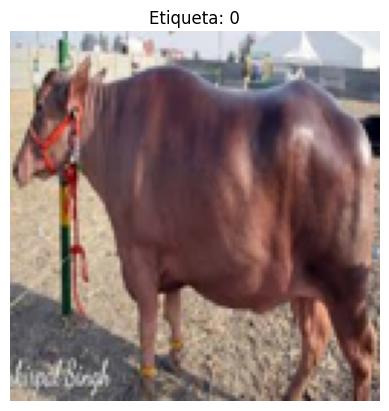

In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

resize_dim = (128, 128)
common_mode = "RGB"

def preprocess_images_from_directory(directory, resize_dim, common_mode):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    if img.mode != common_mode:
                        img = img.convert(common_mode)
                    img = img.resize(resize_dim)
                    img = np.array(img) / 255.0  # Normalizar entre 0 y 1
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Preprocesar imágenes de entrenamiento y prueba
X_train, y_train = preprocess_images_from_directory(train_dir, resize_dim, common_mode)
X_test, y_test = preprocess_images_from_directory(test_dir, resize_dim, common_mode)

# Convertir etiquetas en categorías numéricas
label_to_index = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train = np.array([label_to_index[label] for label in y_train])
y_test = np.array([label_to_index[label] for label in y_test])

# Visualizar información del dataset preprocesado
print(f"Número de imágenes de entrenamiento: {X_train.shape[0]}")
print(f"Número de imágenes de prueba: {X_test.shape[0]}")
print(f"Dimensiones de las imágenes: {X_train.shape[1:]}")
print(f"Etiquetas: {label_to_index}")

# Ejemplo de imagen preprocesada y su etiqueta
plt.imshow(X_train[0])
plt.title(f"Etiqueta: {y_train[0]}")
plt.axis("off")
plt.show()


# Importación de Librerías y Configuración de la GPU

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import time
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuraciones de la GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Limpiar el caché de la GPU
torch.cuda.empty_cache()

# Definición de Directorios y Transformaciones de Datos

In [6]:
# Rutas a los directorios de datos
train_dir = r'C:\Users\Jesus\Desktop\dataset\train'
test_dir = r'C:\Users\Jesus\Desktop\dataset\test'

# Transformaciones para la data de entrenamiento y prueba
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de Datos y Preparación de Dataloaders

In [7]:
# Data loader
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

# División del conjunto de datos de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Incrementar batch size a 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verificar la carga de imágenes y carpetas
print(f'Clases encontradas en entrenamiento: {full_train_dataset.classes}')
print(f'Número de imágenes en entrenamiento: {len(train_dataset)}')
print(f'Número de imágenes en validación: {len(val_dataset)}')
print(f'Número de imágenes en prueba: {len(test_dataset)}')

Clases encontradas en entrenamiento: ['Buffalo', 'Elephant', 'Rhino', 'Zebra']
Número de imágenes en entrenamiento: 2560
Número de imágenes en validación: 640
Número de imágenes en prueba: 800


# Definición de la Red Neuronal

In [8]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, len(full_train_dataset.classes)),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ImprovedCNN().to(device)


# Configuración del Optimizador, Función de Pérdida y Scheduler

In [9]:
# Configuración del optimizador, función de pérdida y scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


# Implementación de Early Stopping

In [10]:
# Implementación de Early Stopping con paciencia de 10
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=10, min_delta=0.001)


#  Función para Calcular Precisión

In [11]:
# Función para calcular la precisión
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data).item() / len(labels)


# Entrenamiento del Modelo

In [13]:
# Entrenamiento del modelo
def train_model_with_accuracy(model, criterion, optimizer, scheduler, num_epochs=100):
    print("Training model...")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        start_time = time.time()
        
        # Entrenamiento
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validación
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += calculate_accuracy(val_outputs, val_labels) * val_inputs.size(0)
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects / len(val_dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        scheduler.step(val_epoch_loss)
        
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Time: {time.time() - start_time:.2f}s")
        
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    model.load_state_dict(best_model_wts)
    print("Training completed")
    return model, train_losses, val_losses, train_accuracies, val_accuracies

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_accuracy(model, criterion, optimizer, scheduler, num_epochs=50)


Training model...


Epoch 1/50, Train Loss: 0.9389, Train Acc: 0.5391, Val Loss: 0.8866, Val Acc: 0.5969, Time: 28.90s


Epoch 2/50, Train Loss: 0.8390, Train Acc: 0.6156, Val Loss: 0.9615, Val Acc: 0.6094, Time: 28.25s


Epoch 3/50, Train Loss: 0.7797, Train Acc: 0.6754, Val Loss: 0.7178, Val Acc: 0.6984, Time: 28.12s


Epoch 4/50, Train Loss: 0.7323, Train Acc: 0.6961, Val Loss: 0.9840, Val Acc: 0.6250, Time: 28.16s


Epoch 5/50, Train Loss: 0.6718, Train Acc: 0.7250, Val Loss: 0.6861, Val Acc: 0.7172, Time: 29.54s


Epoch 6/50, Train Loss: 0.6448, Train Acc: 0.7324, Val Loss: 0.6535, Val Acc: 0.7578, Time: 29.31s


Epoch 7/50, Train Loss: 0.5975, Train Acc: 0.7602, Val Loss: 0.5595, Val Acc: 0.7781, Time: 28.05s


Epoch 8/50, Train Loss: 0.5536, Train Acc: 0.7777, Val Loss: 0.6345, Val Acc: 0.7453, Time: 28.11s


Epoch 9/50, Train Loss: 0.5448, Train Acc: 0.7863, Val Loss: 0.5681, Val Acc: 0.7906, Time: 29.15s


Epoch 10/50, Train Loss: 0.5160, Train Acc: 0.7926, Val Loss: 0.8416, Val Acc: 0.7422, Time: 28.30s


Epoch 11/50, Train Loss: 0.4958, Train Acc: 0.7941, Val Loss: 0.7129, Val Acc: 0.7359, Time: 27.99s


Epoch 12/50, Train Loss: 0.4484, Train Acc: 0.8277, Val Loss: 0.5159, Val Acc: 0.8000, Time: 28.04s


Epoch 13/50, Train Loss: 0.4356, Train Acc: 0.8262, Val Loss: 0.7008, Val Acc: 0.7312, Time: 28.09s


Epoch 14/50, Train Loss: 0.4231, Train Acc: 0.8391, Val Loss: 0.5405, Val Acc: 0.8031, Time: 28.01s


Epoch 15/50, Train Loss: 0.3999, Train Acc: 0.8535, Val Loss: 0.4997, Val Acc: 0.8109, Time: 28.08s


Epoch 16/50, Train Loss: 0.3794, Train Acc: 0.8520, Val Loss: 0.4931, Val Acc: 0.8344, Time: 28.20s


Epoch 17/50, Train Loss: 0.3558, Train Acc: 0.8652, Val Loss: 0.4830, Val Acc: 0.8094, Time: 27.91s


Epoch 18/50, Train Loss: 0.3319, Train Acc: 0.8809, Val Loss: 0.4638, Val Acc: 0.8391, Time: 27.89s


Epoch 19/50, Train Loss: 0.3320, Train Acc: 0.8793, Val Loss: 0.5996, Val Acc: 0.8078, Time: 27.91s


Epoch 20/50, Train Loss: 0.3358, Train Acc: 0.8773, Val Loss: 0.8130, Val Acc: 0.7125, Time: 28.05s


Epoch 21/50, Train Loss: 0.3195, Train Acc: 0.8816, Val Loss: 0.3450, Val Acc: 0.8766, Time: 28.04s


Epoch 22/50, Train Loss: 0.2796, Train Acc: 0.8949, Val Loss: 0.6103, Val Acc: 0.8031, Time: 27.93s


Epoch 23/50, Train Loss: 0.2923, Train Acc: 0.8926, Val Loss: 0.3647, Val Acc: 0.8672, Time: 28.09s


Epoch 24/50, Train Loss: 0.2664, Train Acc: 0.8988, Val Loss: 0.4882, Val Acc: 0.8250, Time: 28.10s


Epoch 25/50, Train Loss: 0.2607, Train Acc: 0.9051, Val Loss: 0.3808, Val Acc: 0.8531, Time: 27.92s


Epoch 26/50, Train Loss: 0.2454, Train Acc: 0.9016, Val Loss: 0.4151, Val Acc: 0.8359, Time: 28.02s


Epoch 27/50, Train Loss: 0.2633, Train Acc: 0.9043, Val Loss: 0.3324, Val Acc: 0.8750, Time: 28.20s


Epoch 28/50, Train Loss: 0.2208, Train Acc: 0.9195, Val Loss: 0.3665, Val Acc: 0.8766, Time: 27.98s


Epoch 29/50, Train Loss: 0.2340, Train Acc: 0.9129, Val Loss: 0.9047, Val Acc: 0.7250, Time: 27.94s


Epoch 30/50, Train Loss: 0.2341, Train Acc: 0.9062, Val Loss: 0.3991, Val Acc: 0.8703, Time: 28.10s


Epoch 31/50, Train Loss: 0.1815, Train Acc: 0.9297, Val Loss: 0.3398, Val Acc: 0.8750, Time: 28.06s


Epoch 32/50, Train Loss: 0.2386, Train Acc: 0.9152, Val Loss: 0.3884, Val Acc: 0.8625, Time: 28.15s


Epoch 33/50, Train Loss: 0.2045, Train Acc: 0.9246, Val Loss: 0.3355, Val Acc: 0.8891, Time: 27.80s


Epoch 34/50, Train Loss: 0.1524, Train Acc: 0.9453, Val Loss: 0.3010, Val Acc: 0.8922, Time: 28.00s


Epoch 35/50, Train Loss: 0.1279, Train Acc: 0.9551, Val Loss: 0.2912, Val Acc: 0.9094, Time: 28.00s


Epoch 36/50, Train Loss: 0.1358, Train Acc: 0.9520, Val Loss: 0.2648, Val Acc: 0.9016, Time: 28.07s


Epoch 37/50, Train Loss: 0.1194, Train Acc: 0.9613, Val Loss: 0.3237, Val Acc: 0.9047, Time: 27.93s


Epoch 38/50, Train Loss: 0.1154, Train Acc: 0.9559, Val Loss: 0.2760, Val Acc: 0.9031, Time: 28.10s


Epoch 39/50, Train Loss: 0.1021, Train Acc: 0.9609, Val Loss: 0.3838, Val Acc: 0.8797, Time: 28.15s


Epoch 40/50, Train Loss: 0.1132, Train Acc: 0.9590, Val Loss: 0.3800, Val Acc: 0.8656, Time: 28.02s


Epoch 41/50, Train Loss: 0.1132, Train Acc: 0.9617, Val Loss: 0.2488, Val Acc: 0.9141, Time: 28.03s


Epoch 42/50, Train Loss: 0.1124, Train Acc: 0.9559, Val Loss: 0.2962, Val Acc: 0.8938, Time: 28.25s


Epoch 43/50, Train Loss: 0.0899, Train Acc: 0.9684, Val Loss: 0.5076, Val Acc: 0.8734, Time: 28.18s


Epoch 44/50, Train Loss: 0.1016, Train Acc: 0.9625, Val Loss: 0.2830, Val Acc: 0.8969, Time: 28.07s


Epoch 45/50, Train Loss: 0.0995, Train Acc: 0.9641, Val Loss: 0.3562, Val Acc: 0.8891, Time: 27.97s


Epoch 46/50, Train Loss: 0.0953, Train Acc: 0.9676, Val Loss: 0.2989, Val Acc: 0.8953, Time: 28.15s


Epoch 47/50, Train Loss: 0.1008, Train Acc: 0.9613, Val Loss: 0.2693, Val Acc: 0.9141, Time: 28.27s


Epoch 48/50, Train Loss: 0.0739, Train Acc: 0.9730, Val Loss: 0.2550, Val Acc: 0.9141, Time: 27.97s


Epoch 49/50, Train Loss: 0.0590, Train Acc: 0.9793, Val Loss: 0.2726, Val Acc: 0.9094, Time: 28.05s


Epoch 50/50, Train Loss: 0.0643, Train Acc: 0.9746, Val Loss: 0.2446, Val Acc: 0.9250, Time: 28.19s
Training completed


# Evaluación del Modelo

In [14]:
# Evaluación del modelo en el conjunto de prueba
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_total = 0
    class_correct = list(0. for i in range(len(full_train_dataset.classes)))
    class_total = list(0. for i in range(len(full_train_dataset.classes)))
    
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            _, test_preds = torch.max(test_outputs, 1)
            test_corrects += torch.sum(test_preds == test_labels.data).item()
            test_total += test_labels.size(0)
            
            c = (test_preds == test_labels.data).squeeze()
            for i in range(len(test_labels)):
                label = test_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    test_loss /= len(test_loader)
    test_accuracy = test_corrects / test_total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    for i in range(len(full_train_dataset.classes)):
        if class_total[i] > 0:
            print(f"Accuracy of class {full_train_dataset.classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
        else:
            print(f"Accuracy of class {full_train_dataset.classes[i]}: N/A (no samples)")

evaluate_model(model, test_loader)


Test Loss: 0.1969, Test Accuracy: 0.9387
Accuracy of class Buffalo: 95.00% (190/200)
Accuracy of class Elephant: 90.50% (181/200)
Accuracy of class Rhino: 91.50% (183/200)
Accuracy of class Zebra: 98.50% (197/200)


# Graficar Pérdida y Precisión

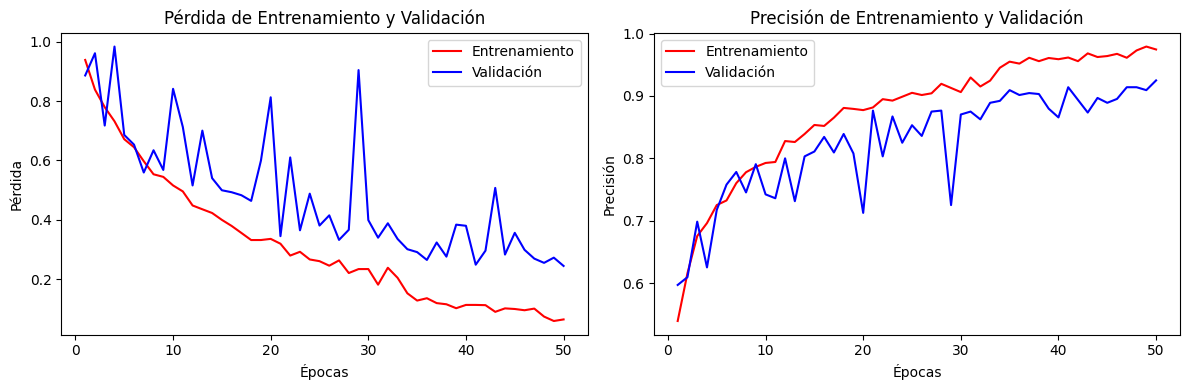

In [15]:
# Graficar las pérdidas y precisiones de entrenamiento y validación
def plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Entrenamiento')
    plt.plot(epochs, val_losses, 'b', label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Pérdida de Entrenamiento y Validación')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Entrenamiento')
    plt.plot(epochs, val_accuracies, 'b', label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Precisión de Entrenamiento y Validación')
    
    plt.tight_layout()
    plt.show()

plot_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)


## Metricas

Accuracy: 0.9213
Precision: 0.9226
Recall: 0.9213
F1 Score: 0.9213
Confusion Matrix:
[[191   6   3   0]
 [ 12 179   7   2]
 [ 11  13 175   1]
 [  2   3   3 192]]
True Negatives: 191
False Negatives: 12
True Positives: 179
False Positives: 6


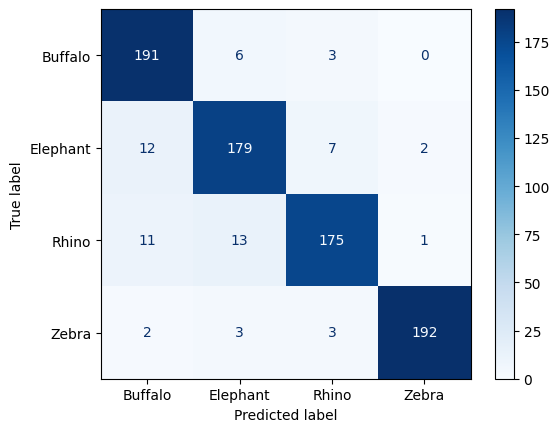

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Función para calcular y mostrar las métricas
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    
    tn = cm[0, 0]
    fn = cm[1, 0]
    tp = cm[1, 1]
    fp = cm[0, 1]
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_train_dataset.classes)
    disp.plot(cmap='Blues')
    plt.show()

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader)


# Comparativa real vs prediccion

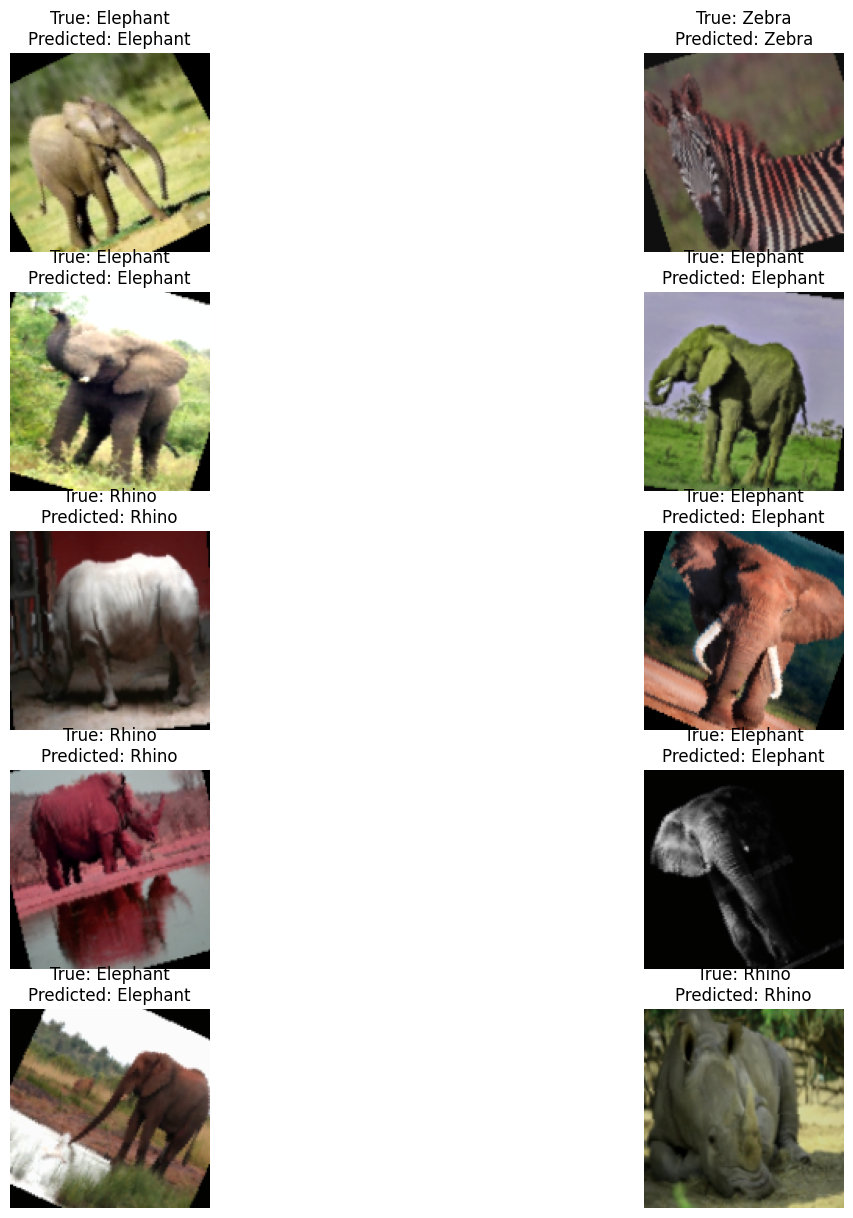

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Función para mostrar imagen con predicción
def imshow_with_prediction(img, true_label, predicted_label):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

# Función para mostrar comparativa de imágenes originales vs predicción
def compare_predictions(model, test_loader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    
    # Seleccionar aleatoriamente un número de imágenes
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                all_images.append(inputs.cpu().data[j])
                all_labels.append(labels[j])
                all_preds.append(preds[j])
    
    random_indices = random.sample(range(len(all_images)), num_images)
    
    for idx in random_indices:
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        
        imshow_with_prediction(all_images[idx], 
                               full_train_dataset.classes[all_labels[idx]], 
                               full_train_dataset.classes[all_preds[idx]])
        
        if images_so_far == num_images:
            break

compare_predictions(model, test_loader, num_images=10)

